# CNN with MNIST Data

In this notebook I'll build a Convolutional neural network using keras framework. The optimal model is achieved after many trial and error which I'll depict here in step by step procedure. 

A very basic question is why one should go for CNN when images are concered?

When I was starting with CNN this was the first question that came in mind. After I had enough experience with CNNs, I was finally able to answer this(ofcourse you can find thousands of explainations online too). CNNs are good in expressing the data rather than just start processing it. While using CNNs, we preserve the spatial information of pixels(we dont have to reshape input images) which let us focus on the correlation of adjacent pixels. This is motivated by the way human visualization work. 
The processing part is done by the Dense layers we add after the convolutional layers.

Enough talk, let's get to work.

In [1]:
# Import all the required libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, BatchNormalization, Reshape 
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor= 'val_loss',
                             factor= 0.2,
                             patience= 2,
                             min_lr = 0.00001)

In [2]:
# load data
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# prepare data
X_train = train.drop(['label'], axis= 1).values.reshape(-1, 28, 28, 1)
y_train = to_categorical(train['label'].values)

X_test = test.values.reshape(-1, 28, 28, 1)

In [5]:
print('shape of train set: ',X_train.shape)
print('shape of test set: ',X_test.shape)

shape of train set:  (42000, 28, 28, 1)
shape of test set:  (28000, 28, 28, 1)


## The foundation model

I'll start with the most basic model with one Conv2d layer followed by a pooling layer and finally a dense layer.

Epoch 1/10
420/420 [==============================] - 12s 28ms/step - loss: 1.5192 - accuracy: 0.9114 - val_loss: 0.1532 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 2/10
420/420 [==============================] - 11s 26ms/step - loss: 0.0873 - accuracy: 0.9749 - val_loss: 0.1344 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/10
420/420 [==============================] - 11s 26ms/step - loss: 0.0527 - accuracy: 0.9841 - val_loss: 0.1288 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 4/10
420/420 [==============================] - 11s 26ms/step - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.1076 - val_accuracy: 0.9748 - lr: 0.0010
Epoch 5/10
420/420 [==============================] - 11s 26ms/step - loss: 0.0250 - accuracy: 0.9918 - val_loss: 0.1130 - val_accuracy: 0.9752 - lr: 0.0010
Epoch 6/10
420/420 [==============================] - 12s 28ms/step - loss: 0.0220 - accuracy: 0.9923 - val_loss: 0.1284 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/10
420/420 [==============================] - 11s 

(0.97, 1.0)

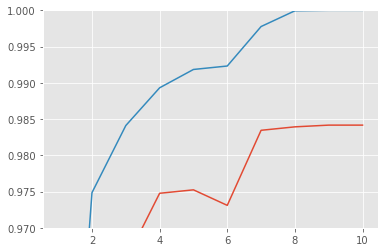

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size= 3, padding= 'same',\
                 activation= 'relu', input_shape= (28, 28, 1)))
model.add(MaxPool2D(2))
model.add(Flatten())
model.add(Dense(256, activation= 'relu'))
#output
model.add(Dense(10, activation= 'softmax'))

# compile the model
model.compile(loss= 'categorical_crossentropy', metrics= ['accuracy'],\
             optimizer= 'adam')

# fit the model
epochs = 10
history = model.fit(X_train, y_train, callbacks= [reduce_lr],\
          validation_split= 0.2, epochs= epochs, batch_size= 80)

# plot learning curves
plt.plot(np.arange(1, epochs+ 1), history.history['val_accuracy'])
plt.plot(np.arange(1, epochs+ 1), history.history['accuracy'])
plt.ylim(0.97, 1)

## First Trial

Now we'll start tweaking our base model to improve efficiency while maintaining minimal computational cost.

First experiment is to add more convolutional layers to the network.
First few conv layers good at identifying general features like edges. Later conv layers start differentiating more complex features in the image like object identification. 

I'll try models with two and three conv layers. Adding a forth layer will not be feasible as after 3rd conv layer the size of image is already very small(because of pooling).

In [7]:
# Build CNN
num = 3
model = [0]* 3

for i in range(num):
    model[i] = Sequential()
    model[i].add(Conv2D(32, kernel_size= 3, activation= 'relu',\
                       input_shape= (28, 28, 1), padding= 'same'))
    model[i].add(MaxPool2D(2))
    if i > 0:
        model[i].add(Conv2D(32, kernel_size= 3, activation= 'relu', padding= 'same'))
        model[i].add(MaxPool2D(2))
    if i > 1:
        model[i].add(Conv2D(32, kernel_size= 3, activation= 'relu', padding= 'same'))
        model[i].add(MaxPool2D(2))
    
    model[i].add(Flatten())
    model[i].add(Dense(256, activation= 'relu'))
    model[i].add(Dense(10, activation= 'softmax'))
    
    # compile model
    model[i].compile(loss= 'categorical_crossentropy', 
                    optimizer= 'adam',
                    metrics= ['accuracy'])

In [8]:
# fit the models

epochs= 15
history = [0]*num

for j in range(num):
    history[j] = model[j].fit(X_train, y_train, validation_split= 0.3,\
            epochs= epochs, callbacks= [reduce_lr],verbose=2, batch_size= 80)
    print('Model {} trained'.format(j+1))

Epoch 1/15
368/368 - 11s - loss: 1.9407 - accuracy: 0.9107 - val_loss: 0.1724 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 2/15
368/368 - 10s - loss: 0.1175 - accuracy: 0.9706 - val_loss: 0.1475 - val_accuracy: 0.9685 - lr: 0.0010
Epoch 3/15
368/368 - 10s - loss: 0.0562 - accuracy: 0.9841 - val_loss: 0.1258 - val_accuracy: 0.9716 - lr: 0.0010
Epoch 4/15
368/368 - 10s - loss: 0.0300 - accuracy: 0.9905 - val_loss: 0.1256 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 5/15
368/368 - 10s - loss: 0.0220 - accuracy: 0.9930 - val_loss: 0.1357 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 6/15
368/368 - 10s - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.1444 - val_accuracy: 0.9729 - lr: 0.0010
Epoch 7/15
368/368 - 10s - loss: 0.0054 - accuracy: 0.9982 - val_loss: 0.1075 - val_accuracy: 0.9802 - lr: 2.0000e-04
Epoch 8/15
368/368 - 10s - loss: 9.2314e-04 - accuracy: 0.9999 - val_loss: 0.1057 - val_accuracy: 0.9804 - lr: 2.0000e-04
Epoch 9/15
368/368 - 10s - loss: 5.1880e-04 - accuracy: 1.0000 - val_loss: 0

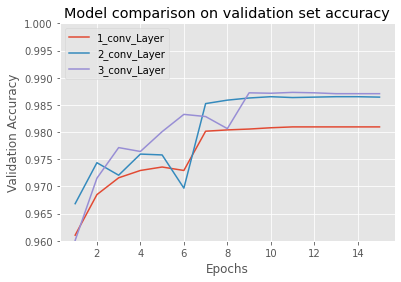

In [9]:
# plot learning curves

for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'], label= '{}_conv_Layer'.format(i+1))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

CNN with 2 Convolutional layers performed better. 
CNN with 3 Conv layers performed bad because the number of parameters decreased significantly.

## Second Trial

Different number of feature maps in each Conv layer greatly affects the model in terms of number of paramters. Feature maps usually increase in deeper Conv layers.

**Cases**:
1. 10, 20
2. 16, 32
3. 32, 64
4. 64, 128

These are the number of convolutions in the two layers

In [10]:
# Build CNN
num = 4
model = [0]*num

for i in range(num):
    model[i] = Sequential()
    
    model[i].add(Conv2D(2**(i+3), kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1),\
                       padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Conv2D(2**(i+4), kernel_size= 3, activation= 'relu', padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Flatten())
    model[i].add(Dense(256, activation= 'relu'))
    model[i].add(Dense(10, activation= 'softmax'))
    
    # compile model
    model[i].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [11]:
# fit the models
history = [0]*num
epochs= 15

for j in range(num):
    history[j] = model[j].fit(X_train, y_train, validation_split= 0.3,\
            epochs= epochs, callbacks= [reduce_lr],verbose=0, batch_size= 80)
    print('Model {} trained'.format(j+1))

Model 1 trained
Model 2 trained
Model 3 trained
Model 4 trained


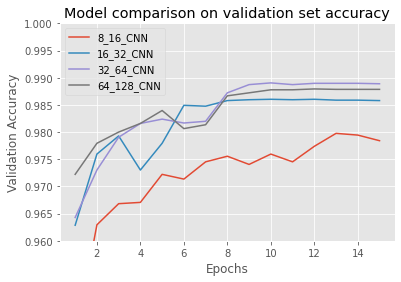

In [12]:
# plot learning curves
for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'],\
             label= '{}_{}_CNN'.format(2**(i+3), 2**(i+4)))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

Model having 32 kernels in first Conv layer and 64 kernels in second Conv layer performed equally good as with 64, 128. Keeping in mind the computational cost, we'll go with 32, 64

## Third Trial

Let us see the kernel size effect on the network

**Cases**:
1. 3x3
2. 5x5
3. 7x7
4. 9x9

These are the dimensions of kernel matrix

In [13]:
# Build CNN
num= 4
model = [0]*num

for i in range(num):
    model[i] = Sequential()
    
    model[i].add(Conv2D(32, kernel_size= 3 + i*2, activation= 'relu', input_shape= (28, 28, 1),\
                       padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Conv2D(64, kernel_size= 3 + i*2, activation= 'relu', padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Flatten())
    model[i].add(Dense(256, activation= 'relu'))
    model[i].add(Dense(10, activation= 'softmax'))
                 
    # Compile
    model[i].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    

In [14]:
# fit the data
history = [0]*num
epochs= 15

for j in range(num):
    history[j] = model[j].fit(X_train, y_train, validation_split= 0.3,\
            epochs= epochs, callbacks= [reduce_lr],verbose=0, batch_size= 80)
    print('Model {} trained'.format(j+1))

Model 1 trained
Model 2 trained
Model 3 trained
Model 4 trained


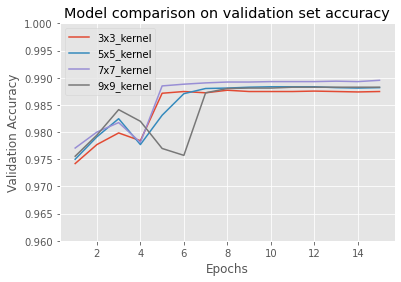

In [15]:
# plot learing curves
for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'],\
             label= '{}x{}_kernel'.format(3 + i*2, 3 + i*2))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

3x3 kernel performed better than any other size.  

## Forth Trial

Number of Dense layers 
**Cases**: 1, 2, 3 Dense layers

In [16]:
# Build CNN
num = 3
model = [0]*num

for i in range(num):
    model[i] = Sequential()
    
    model[i].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Flatten())
    model[i].add(Dense(128, activation= 'relu'))
    
    if i > 0:
        model[i].add(Dense(128, activation= 'relu'))
    if i > 1:
        model[i].add(Dense(128, activation= 'relu'))
        
    model[i].add(Dense(10, activation= 'softmax'))
    
    # compile
    model[i].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    

In [17]:
# fit the data
history = [0]*num
epochs= 15

for j in range(num):
    history[j] = model[j].fit(X_train, y_train, validation_split= 0.3, callbacks= [reduce_lr],\
                             epochs= epochs, batch_size= 80, verbose= 0)
    print('Model {} is trained'.format(j+1))

Model 1 is trained
Model 2 is trained
Model 3 is trained


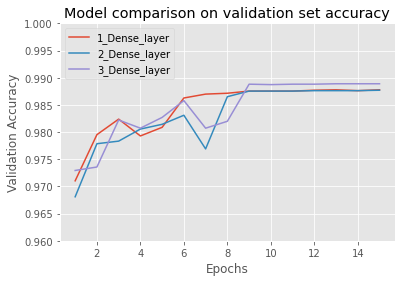

In [18]:
# plot learing curves
for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'],\
             label= '{}_Dense_layer'.format(i+1))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

1 Dense layer is enough for our model. we'll not go for 3 layers as it does not result in any significant change in accuracy.

## Fifth Trial

Size of Dense layers.

**Cases**: 32, 64, 128, 256

In [19]:
# Build CNN
num = 4
model = [0]*4

for i in range(num):
    model[i] = Sequential()
    
    model[i].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
    model[i].add(MaxPool2D(2))
    
    model[i].add(Flatten())
    model[i].add(Dense(2**(i+5), activation= 'relu'))
    model[i].add(Dense(10, activation= 'softmax'))
    
    # compile
    model[i].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
    

In [20]:
# fit the data
history = [0]*num
epochs= 15

for j in range(num):
    history[j] = model[j].fit(X_train, y_train, validation_split= 0.3, callbacks= [reduce_lr],\
                             epochs= epochs, batch_size= 80, verbose= 0)
    print('Model {} is trained'.format(j+1))

Model 1 is trained
Model 2 is trained
Model 3 is trained
Model 4 is trained


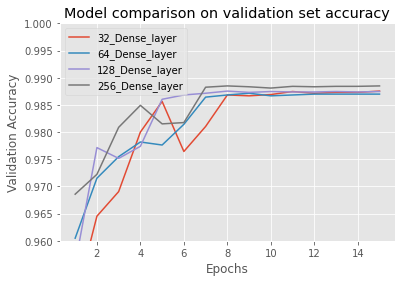

In [21]:
# plot learing curves
for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'],\
             label= '{}_Dense_layer'.format(2**(i+5)))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

256 neurons in the Dense layer.

## Sixth Trial

Dropout in the network
**Cases**:
0%, 10%, 20%, 30%, 40%, 50%, 60%

In [22]:
# Build CNN
num = 7
model = [0]*num

for i in range(num):
    model[i] = Sequential()
    
    model[i].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
    model[i].add(MaxPool2D(2))
    model[i].add(Dropout(i*0.1))
    
    model[i].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
    model[i].add(MaxPool2D(2))
    model[i].add(Dropout(i*0.1))
    
    model[i].add(Flatten())
    model[i].add(Dense(256, activation= 'relu'))
    model[i].add(Dropout(i*0.1))
    model[i].add(Dense(10, activation= 'softmax'))
    
    # compile
    model[i].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [23]:
# fit the data
history = [0]*num
epochs= 20

for j in range(num):
    history[j] = model[j].fit(X_train, y_train, validation_split= 0.3, callbacks= [reduce_lr],\
                             epochs= epochs, batch_size= 80, verbose= 0)
    print('Model {} is trained'.format(j+1))

Model 1 is trained
Model 2 is trained
Model 3 is trained
Model 4 is trained
Model 5 is trained
Model 6 is trained
Model 7 is trained


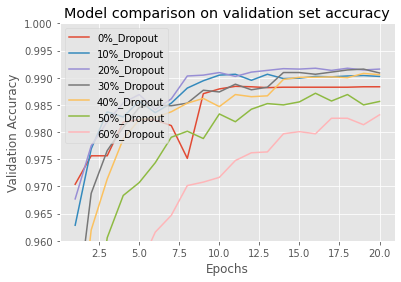

In [24]:
# plot learning curve
for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'],\
             label= '{}%_Dropout'.format(i*10))
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

10% dropout is enough for our model

## Seventh Trial

Now we'll try some advance concepts 

1. Data Augmentation
2. Batch normalization
3. Using Conv layers with stride=2 in place of Pooling layers

In [25]:
# Build CNN
num = 5
model= [0]*num
history = [0]*num
epochs= 20

# Basic model

model[0] = Sequential()
    
model[0].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
model[0].add(MaxPool2D(2))
model[0].add(Dropout(0.1))

model[0].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
model[0].add(MaxPool2D(2))
model[0].add(Dropout(0.1))

model[0].add(Flatten())
model[0].add(Dense(256, activation= 'relu'))
model[0].add(Dropout(0.1))
model[0].add(Dense(10, activation= 'softmax'))

# compile
model[0].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])


# fit data
history[0] = model[0].fit(X_train, y_train, validation_split= 0.3, callbacks= [reduce_lr],\
                             epochs= epochs, batch_size= 80, verbose= 2)

Epoch 1/20
368/368 - 20s - loss: 1.4421 - accuracy: 0.8818 - val_loss: 0.0857 - val_accuracy: 0.9721 - lr: 0.0010
Epoch 2/20
368/368 - 20s - loss: 0.1101 - accuracy: 0.9669 - val_loss: 0.0656 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 3/20
368/368 - 19s - loss: 0.0768 - accuracy: 0.9758 - val_loss: 0.0567 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 4/20
368/368 - 19s - loss: 0.0598 - accuracy: 0.9810 - val_loss: 0.0635 - val_accuracy: 0.9810 - lr: 0.0010
Epoch 5/20
368/368 - 20s - loss: 0.0480 - accuracy: 0.9844 - val_loss: 0.0624 - val_accuracy: 0.9829 - lr: 0.0010
Epoch 6/20
368/368 - 22s - loss: 0.0262 - accuracy: 0.9909 - val_loss: 0.0401 - val_accuracy: 0.9884 - lr: 2.0000e-04
Epoch 7/20
368/368 - 19s - loss: 0.0203 - accuracy: 0.9934 - val_loss: 0.0395 - val_accuracy: 0.9883 - lr: 2.0000e-04
Epoch 8/20
368/368 - 20s - loss: 0.0161 - accuracy: 0.9948 - val_loss: 0.0379 - val_accuracy: 0.9891 - lr: 2.0000e-04
Epoch 9/20
368/368 - 19s - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.039

In [26]:
# Model with Data augmentation
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train, y_train, test_size= 0.3)

datagen = ImageDataGenerator(featurewise_center= False,
                             samplewise_center= False,
                             featurewise_std_normalization= False,
                             samplewise_std_normalization= False,
                             zca_whitening= False,
                             rotation_range= 10,
                             zoom_range = 0.1,
                             width_shift_range= 0.1,
                             height_shift_range= 0.1,
                             horizontal_flip= False,
                             vertical_flip= False)

datagen.fit(X_train)

In [27]:
model[1] = Sequential()
    
model[1].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
model[1].add(MaxPool2D(2))
model[1].add(Dropout(0.1))

model[1].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
model[1].add(MaxPool2D(2))
model[1].add(Dropout(0.1))

model[1].add(Flatten())
model[1].add(Dense(256, activation= 'relu'))
model[1].add(Dropout(0.1))
model[1].add(Dense(10, activation= 'softmax'))

# compile
model[1].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

# fit data
history[1] = model[1].fit(datagen.flow(X_train2, y_train2, batch_size= 80),validation_data= (X_val2, y_val2),\
                         steps_per_epoch= X_train2.shape[0]//80, epochs= epochs, callbacks= [reduce_lr],\
                         verbose= 2)

Epoch 1/20
367/367 - 23s - loss: 1.3444 - accuracy: 0.8138 - val_loss: 0.0881 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 2/20
367/367 - 23s - loss: 0.1780 - accuracy: 0.9439 - val_loss: 0.0580 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 3/20
367/367 - 23s - loss: 0.1356 - accuracy: 0.9583 - val_loss: 0.0588 - val_accuracy: 0.9816 - lr: 0.0010
Epoch 4/20
367/367 - 23s - loss: 0.1145 - accuracy: 0.9637 - val_loss: 0.0506 - val_accuracy: 0.9848 - lr: 0.0010
Epoch 5/20
367/367 - 23s - loss: 0.0984 - accuracy: 0.9686 - val_loss: 0.0489 - val_accuracy: 0.9852 - lr: 0.0010
Epoch 6/20
367/367 - 23s - loss: 0.0891 - accuracy: 0.9720 - val_loss: 0.0441 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 7/20
367/367 - 23s - loss: 0.0820 - accuracy: 0.9748 - val_loss: 0.0416 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 8/20
367/367 - 23s - loss: 0.0779 - accuracy: 0.9760 - val_loss: 0.0592 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 9/20
367/367 - 23s - loss: 0.0764 - accuracy: 0.9758 - val_loss: 0.0503 - val_accu

In [28]:
# model with batch normalization 
model[2] = Sequential()
    
model[2].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
model[2].add(MaxPool2D(2))
model[2].add(BatchNormalization())
model[2].add(Dropout(0.1))

model[2].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
model[2].add(MaxPool2D(2))
model[2].add(BatchNormalization())
model[2].add(Dropout(0.1))

model[2].add(Flatten())
model[2].add(Dense(256, activation= 'relu'))
model[2].add(BatchNormalization())
model[2].add(Dropout(0.1))
model[2].add(Dense(10, activation= 'softmax'))

# compile
model[2].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [29]:
# fit the data
history[2] = model[2].fit(X_train, y_train, validation_split= 0.3,\
                         batch_size= 80, epochs= epochs, callbacks= [reduce_lr],\
                         verbose= 2)

Epoch 1/20
368/368 - 22s - loss: 0.1476 - accuracy: 0.9547 - val_loss: 0.0737 - val_accuracy: 0.9779 - lr: 0.0010
Epoch 2/20
368/368 - 22s - loss: 0.0552 - accuracy: 0.9829 - val_loss: 0.0570 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 3/20
368/368 - 22s - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.0491 - val_accuracy: 0.9846 - lr: 0.0010
Epoch 4/20
368/368 - 23s - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0437 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 5/20
368/368 - 22s - loss: 0.0204 - accuracy: 0.9933 - val_loss: 0.0399 - val_accuracy: 0.9889 - lr: 0.0010
Epoch 6/20
368/368 - 22s - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0411 - val_accuracy: 0.9871 - lr: 0.0010
Epoch 7/20
368/368 - 22s - loss: 0.0163 - accuracy: 0.9944 - val_loss: 0.0525 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 8/20
368/368 - 22s - loss: 0.0081 - accuracy: 0.9978 - val_loss: 0.0312 - val_accuracy: 0.9915 - lr: 2.0000e-04
Epoch 9/20
368/368 - 22s - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0310 - val_

In [30]:
# model with no pooling layers
model[3] = Sequential()
    
model[3].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
model[3].add(Conv2D(32, kernel_size= 3, activation= 'relu', strides= 2, padding= 'same'))
model[3].add(Dropout(0.1))

model[3].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
model[3].add(Conv2D(64, kernel_size= 3, activation= 'relu', strides= 2, padding= 'same'))
model[3].add(Dropout(0.1))

model[3].add(Flatten())
model[3].add(Dense(256, activation= 'relu'))
model[3].add(Dropout(0.1))
model[3].add(Dense(10, activation= 'softmax'))

# compile
model[3].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [31]:
# fit data
history[3] = model[3].fit(X_train, y_train, validation_split= 0.3,\
                         batch_size= 80, epochs= epochs, callbacks= [reduce_lr],\
                         verbose= 2)

Epoch 1/20
368/368 - 32s - loss: 0.3744 - accuracy: 0.9100 - val_loss: 0.0819 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 2/20
368/368 - 29s - loss: 0.0769 - accuracy: 0.9750 - val_loss: 0.0674 - val_accuracy: 0.9793 - lr: 0.0010
Epoch 3/20
368/368 - 28s - loss: 0.0562 - accuracy: 0.9822 - val_loss: 0.0527 - val_accuracy: 0.9839 - lr: 0.0010
Epoch 4/20
368/368 - 28s - loss: 0.0373 - accuracy: 0.9878 - val_loss: 0.0545 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/20
368/368 - 28s - loss: 0.0329 - accuracy: 0.9890 - val_loss: 0.0473 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 6/20
368/368 - 28s - loss: 0.0315 - accuracy: 0.9899 - val_loss: 0.0539 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/20
368/368 - 27s - loss: 0.0316 - accuracy: 0.9893 - val_loss: 0.0400 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 8/20
368/368 - 28s - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0477 - val_accuracy: 0.9877 - lr: 0.0010
Epoch 9/20
368/368 - 28s - loss: 0.0213 - accuracy: 0.9928 - val_loss: 0.0576 - val_accu

In [32]:
# model with all advance concepts
model[4] = Sequential()
    
model[4].add(Conv2D(32, kernel_size= 3, activation= 'relu', input_shape= (28, 28, 1), padding= 'same'))
model[4].add(BatchNormalization())
model[4].add(Conv2D(32, kernel_size= 3, activation= 'relu', strides= 2, padding= 'same'))
model[4].add(BatchNormalization())
model[4].add(Dropout(0.1))

model[4].add(Conv2D(64, kernel_size= 3, activation= 'relu', padding= 'same'))
model[4].add(BatchNormalization())
model[4].add(Conv2D(64, kernel_size= 3, activation= 'relu', strides= 2, padding= 'same'))
model[4].add(BatchNormalization())
model[4].add(Dropout(0.1))

model[4].add(Flatten())
model[4].add(Dense(256, activation= 'relu'))
model[4].add(BatchNormalization())
model[4].add(Dropout(0.1))
model[4].add(Dense(10, activation= 'softmax'))

# compile
model[4].compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

In [33]:
# fit augmented data
history[4] = model[4].fit(datagen.flow(X_train2, y_train2, batch_size= 80),validation_data= (X_val2, y_val2),\
                         steps_per_epoch= X_train2.shape[0]//80, epochs= epochs, callbacks= [reduce_lr],\
                         verbose= 2)

Epoch 1/20
367/367 - 40s - loss: 0.3201 - accuracy: 0.9012 - val_loss: 0.0990 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 2/20
367/367 - 46s - loss: 0.0978 - accuracy: 0.9683 - val_loss: 0.0772 - val_accuracy: 0.9751 - lr: 0.0010
Epoch 3/20
367/367 - 39s - loss: 0.0737 - accuracy: 0.9765 - val_loss: 0.0481 - val_accuracy: 0.9858 - lr: 0.0010
Epoch 4/20
367/367 - 40s - loss: 0.0621 - accuracy: 0.9803 - val_loss: 0.0460 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 5/20
367/367 - 40s - loss: 0.0578 - accuracy: 0.9826 - val_loss: 0.0388 - val_accuracy: 0.9876 - lr: 0.0010
Epoch 6/20
367/367 - 39s - loss: 0.0522 - accuracy: 0.9835 - val_loss: 0.0538 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/20
367/367 - 38s - loss: 0.0454 - accuracy: 0.9856 - val_loss: 0.0391 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 8/20
367/367 - 38s - loss: 0.0344 - accuracy: 0.9889 - val_loss: 0.0234 - val_accuracy: 0.9934 - lr: 2.0000e-04
Epoch 9/20
367/367 - 39s - loss: 0.0280 - accuracy: 0.9909 - val_loss: 0.0217 - val_

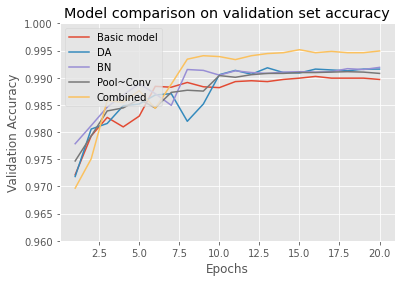

In [34]:
# plot learning curves
labels = ['Basic model',
         'DA',
         'BN',
         'Pool~Conv',
         'Combined']
for i in range(num):
    plt.plot(np.arange(1, epochs + 1), history[i].history['val_accuracy'],\
             label= labels[i])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Model comparison on validation set accuracy')
plt.legend(loc= 'upper left')
plt.ylim(0.96, 1)
plt.show()

### Combined model performed significantly better so I'll go with it.

## Predict

In [35]:
# predict with combined model
epochs= 25

model[4].fit_generator(datagen.flow(X_train,y_train, batch_size=64), epochs = epochs, 
    steps_per_epoch = X_train.shape[0]//64, callbacks=[reduce_lr], verbose=0)

# SUBMIT
results = model[4].predict(X_test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST_SUB.csv",index=False)